# Model Stacking
https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

We will use a small multi-class classification problem as the basis to demonstrate the stacking ensemble.

The scikit-learn class provides the make_blobs() function that can be used to create a multi-class classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class.

The problem has two input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same data points.

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line) causing many ambiguous points.

This is desirable as it means that the problem is non-trivial and will allow a neural network model to find many different “good enough” candidate solutions, resulting in a high variance.

In [1]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame# generate 2d classification dataset

Creating 11,000 samples allows us to train on 1,000 and use the remainder as the test dataset for purposes of ensemble training.

In [2]:
X, y = make_blobs(n_samples=11000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))

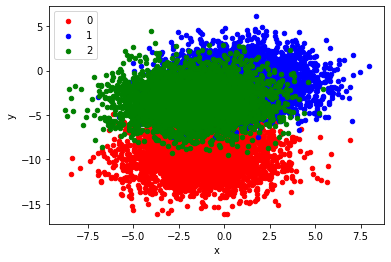

In [3]:
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 1000
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

The model will expect samples with two input variables. The model then has a single hidden layer with 25 nodes and a rectified linear activation function, then an output layer with three nodes to predict the probability of each of the three classes and a softmax activation function.

Because the problem is multi-class, we will use the categorical cross entropy loss function to optimize the model and the efficient Adam flavor of stochastic gradient descent.

In [ ]:
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for 500 training epochs and we will evaluate the model each epoch on the test set, using the test set as a validation set.

In [ ]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

Evaluate model performance.

In [ ]:
#evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Show Model Accuracy (Plot)

In [ ]:
# learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

# Train and Save Sub-Models

To keep this example simple, we will use multiple instances of the same model as level-0 or sub-models in the stacking ensemble.

We will also use a holdout validation dataset to train the level-1 or meta-learner in the ensemble.

A more advanced example may use different types of MLP models (deeper, wider, etc.) as sub-models and train the meta-learner using k-fold cross-validation.

In this section, we will train multiple sub-models and save them to file for later use in our stacking ensembles.

The first step is to create a function that will define and fit an MLP model on the training dataset.

In [ ]:
# fit model on dataset
def fit_model(trainX, trainy):
    # define model
    model = Sequential()
    model.add(Dense(25, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model
    model.fit(trainX, trainy, epochs=500, verbose=0)
    return model

In [ ]:
# create directory for models
import os

if not ( os.path.isdir('./models') ):
    os.makedirs('models')

Create multiple instances of the MLP and save each to the “models/” subdirectory with a unique filename.

In this case, we will create five sub-models, but you can experiment with a different number of models and see how it impacts model performance.

In [ ]:
# fit and save models
n_members = 5
for i in range(n_members):
    # fit model
    model = fit_model(trainX, trainy)
    # save model
    filename = 'models/model_' + str(i + 1) + '.h5'
    model.save(filename)
    print('>Saved %s' % filename)

# Separate Stacking Model

Train a meta-learner that will best combine the predictions from the sub-models and ideally perform better than any single sub-model.

The first step is to load the saved models.

We can use the load_model() Keras function and create a Python list of loaded models.

In [ ]:
from tensorflow.keras.models import load_model

# load models from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models/model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

Load the Models

In [ ]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

Evaluate Each Model's Performance

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from numpy import dstack
 
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX
 
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model
 
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# evaluate standalone models on test dataset
for model in members:
	testy_enc = to_categorical(testy)
	_, acc = model.evaluate(testX, testy_enc, verbose=0)
	print('Model Accuracy: %.3f' % acc)
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy)
# evaluate model on test set
yhat = stacked_prediction(members, model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
#from tensorflow.keras.layers.merge import concatenate
from tensorflow.keras.layers import concatenate
from numpy import argmax
 
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 
# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer.name_enhanced = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(3, activation='softmax')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	#plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
	inputy_enc = to_categorical(inputy)
	# fit model
	model.fit(X, inputy_enc, epochs=300, verbose=0)
 
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=0)
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, testX, testy)
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, testX)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)